In [2]:
# Kaggle House Prices Competition:

# This Notebook contains a summary of my analysis of the House Prices
# competition by Kaggle. First we preprocess the data for machine learning
# with a few simple steps. Using this preprocessed data we train different
# machine learning models which are then stacked to create a meta-model to
# make the final predictions. It might be possible to improve the prediction
# results here by applying more advanced techniques. But these steps are
# sufficient to obtain a Root-Mean-Squared-Error (RMSE) between the logarithm
# of the predicted value and the logarithm of the observed sales price of about
# 0.1175 which puts the submission in the Top 4% on the Public Leaderboard.

In [3]:
# importing necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

from numpy.random import seed
seed(1)

pd.set_option('display.max_rows', 100)

In [4]:
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
# Getting the data

In [5]:
# loading the data

path_to_train_data = 'train.csv'
path_to_test_data = 'test.csv'

train_total = pd.read_csv(path_to_train_data)
test_total = pd.read_csv(path_to_test_data)

In [6]:
# Dividing the train_total data into train and test sets.

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=8)

arrayone = np.ones(len(train_total["SalePrice"]))

for train_index, test_index in split.split(train_total, arrayone):
    train = train_total.iloc[train_index]
    test = train_total.iloc[test_index]
    
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)


In [7]:
# Taking a look at the train data

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,319,60,RL,90.0,9900,Pave,NaN,Reg,Low,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,260000
1,426,60,RM,60.0,3378,Pave,Grvl,Reg,HLS,AllPub,...,0,NaN,NaN,NaN,0,9,2009,WD,Normal,135000
2,880,20,RL,NaN,7000,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,7,2009,WD,Normal,136500
3,1303,60,RL,92.0,10120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2006,WD,Normal,290000
4,1294,60,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,3,2006,WD,Normal,162900


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    964 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          74 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  OverallC

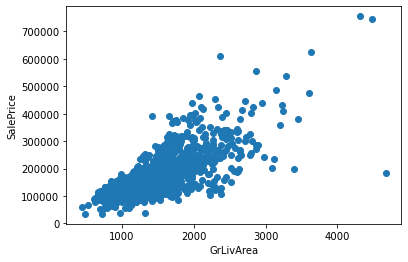

In [9]:
# Lets plot the 'SalePrice' vs 'GrLivArea':

plt.scatter(train['GrLivArea'], train['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In [10]:
# We can see from the plot above that the general relation between 'SalePrice' and 'GrLivArea'
# is a linear relation. That is the case for most of the numerical features.

# There are a few outliers in the data corresponding to 'GrLivArea' > 4000. As we will see
# later these outliers will have a significant negative effect on the prediction error of
# our models. In order to avoid this we will filter these outliers from the main training
# and prediction process using the following filters. Later we make separate predictions
# for them.

filterGrLivArea = 4000

fotrain = (train['GrLivArea'] < filterGrLivArea)

fotest = (test['GrLivArea'] < filterGrLivArea)

fotrain_total = (train_total['GrLivArea'] < filterGrLivArea)

fotest_total = (test_total['GrLivArea'] < filterGrLivArea)

In [11]:
################################################################################################
################################################################################################
################################################################################################
################################################################################################
## Preprocessing the data for machine learning

In [12]:
################################################################################################
################################################################################################
## Imputation of Null values

In [13]:
# Finding columns that contain null values 

nullcoltrain = train.columns[train.isna().any()].tolist()

train[nullcoltrain].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   964 non-null    float64
 1   Alley         74 non-null     object 
 2   MasVnrType    1162 non-null   object 
 3   MasVnrArea    1162 non-null   float64
 4   BsmtQual      1138 non-null   object 
 5   BsmtCond      1138 non-null   object 
 6   BsmtExposure  1137 non-null   object 
 7   BsmtFinType1  1138 non-null   object 
 8   BsmtFinType2  1137 non-null   object 
 9   Electrical    1167 non-null   object 
 10  FireplaceQu   619 non-null    object 
 11  GarageType    1107 non-null   object 
 12  GarageYrBlt   1107 non-null   float64
 13  GarageFinish  1107 non-null   object 
 14  GarageQual    1107 non-null   object 
 15  GarageCond    1107 non-null   object 
 16  PoolQC        6 non-null      object 
 17  Fence         233 non-null    object 
 18  MiscFeature   44 non-null   

In [14]:
# Drop features that contain about half or more null values
# as well as any features related to them. We also drop 'Id'
# and 'SalePrice'

features_to_drop = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature',
                    'MiscVal', 'PoolArea', 'Fireplaces','Id', 'SalePrice']

traind = train.drop(features_to_drop,axis=1)

In [15]:
# Info of null columns of traind

nullcoltraind = traind.columns[traind.isna().any()].tolist()

traind[nullcoltraind].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   964 non-null    float64
 1   MasVnrType    1162 non-null   object 
 2   MasVnrArea    1162 non-null   float64
 3   BsmtQual      1138 non-null   object 
 4   BsmtCond      1138 non-null   object 
 5   BsmtExposure  1137 non-null   object 
 6   BsmtFinType1  1138 non-null   object 
 7   BsmtFinType2  1137 non-null   object 
 8   Electrical    1167 non-null   object 
 9   GarageType    1107 non-null   object 
 10  GarageYrBlt   1107 non-null   float64
 11  GarageFinish  1107 non-null   object 
 12  GarageQual    1107 non-null   object 
 13  GarageCond    1107 non-null   object 
dtypes: float64(3), object(11)
memory usage: 127.9+ KB


In [16]:
# Now we want to fill in the null values. Here there are two types of
# null values:
# 1. Null values that correspond to missing values. For example the LotFrontage
#    null values correspond to missing values in the LotFrontage column.
# 2. Null values that correspond to the absense of a certain feature of the
#    house and can be considered as a sepearate category. For example the null
#    values of the basement columns correspond to houses that have no basement
#    and can be treated as a seperate 'nofeature' category.

In [17]:
####################################################################################
# LotFrontage

# The null values for LotFrontage are missing values in the data and can be
# replaced with the median or mean of the LotFrontage.

In [18]:
####################################################################################
# MasVnrType & MasVnrArea:

traind['MasVnrType'].value_counts()

None       694
BrkFace    355
Stone       98
BrkCmn      15
Name: MasVnrType, dtype: int64

In [19]:
# We'll consider the null values of 'MasVnrType' as the 'None'
# category with zero 'MasVnrArea'.

# Lets check to see if the null values of 'MasVnrType' and 'MasVnrArea' are consistent

traind[traind['MasVnrType'].isna()][['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
25,NaN,NaN
184,NaN,NaN
330,NaN,NaN
347,NaN,NaN
407,NaN,NaN
834,NaN,NaN


In [20]:
####################################################################################
# Basment columns:

#  Basement columns consist of 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
# 'BsmtFinType2' which have null values and 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF' and
# 'TotalBsmtSF' which dont have null values.

# Null values in basement columns correspond to houses that have no basement so they
# can be treated as a separate "nofeature" category.

# There is one extra null value in 'BsmtExposure' and 'BsmtFinType2' which for
# simplicity will be treated similary as mentioned above. Although it might be
# better to replace it with the mode. These small differences will not have an
# effect on the final prediction score therefore we will choose the simpler
# approach which is to replace them with a "nofeature" category.

# Lets see if their (null) values are consistent

traind[traind['BsmtQual'].isna()][['BsmtQual',
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2', 'BsmtFinSF1',
    'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
55,NaN,NaN,NaN,NaN,NaN,0,0,0,0
67,NaN,NaN,NaN,NaN,NaN,0,0,0,0
95,NaN,NaN,NaN,NaN,NaN,0,0,0,0
165,NaN,NaN,NaN,NaN,NaN,0,0,0,0
191,NaN,NaN,NaN,NaN,NaN,0,0,0,0
281,NaN,NaN,NaN,NaN,NaN,0,0,0,0
345,NaN,NaN,NaN,NaN,NaN,0,0,0,0
360,NaN,NaN,NaN,NaN,NaN,0,0,0,0
363,NaN,NaN,NaN,NaN,NaN,0,0,0,0
418,NaN,NaN,NaN,NaN,NaN,0,0,0,0


In [21]:
####################################################################################
# Electrical:

# There is one null value in the 'Electrical' columns which can be replaced with the mode.

traind[(traind['Electrical'].isna())]['Electrical']

751    NaN
Name: Electrical, dtype: object

In [22]:
####################################################################################
# Garage null values:

#  Columns related to Garage are: 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual',
# 'GarageCond' which have null values and 'GarageCars','GarageArea' which do not have null
#  values.

# Null values here correspond to houses that have no Garage which can be considerd as a
# 'nofeature' category.

# Lets see if their (null) values are consistent

traind[(traind['GarageType'].isna())][['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
                                       'GarageArea', 'GarageQual', 'GarageCond']]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
6,NaN,NaN,NaN,0,0,NaN,NaN
55,NaN,NaN,NaN,0,0,NaN,NaN
95,NaN,NaN,NaN,0,0,NaN,NaN
99,NaN,NaN,NaN,0,0,NaN,NaN
119,NaN,NaN,NaN,0,0,NaN,NaN
120,NaN,NaN,NaN,0,0,NaN,NaN
132,NaN,NaN,NaN,0,0,NaN,NaN
191,NaN,NaN,NaN,0,0,NaN,NaN
212,NaN,NaN,NaN,0,0,NaN,NaN
213,NaN,NaN,NaN,0,0,NaN,NaN


In [23]:
# Here we will create a class that will later be used to fill in Null values.

class fillmiss(BaseEstimator, TransformerMixin):
    def __init__(self, columns, strategy):
        self.columns = columns
        self.strategy = strategy
    def fit(self, X, y=None):
        self.dic = {}
        for ind, item in enumerate(self.columns):
            misslen = sum(X[item].isnull())
            if misslen >= 0:
                if self.strategy[ind] == 'median':
                    self.dic[item] = X[item].median()
                if self.strategy[ind] == 'mode':
                    self.dic[item] = X[item].mode()[0]
                if self.strategy[ind] == 'mean':
                    self.dic[item] = X[item].mean()
                
        return self # nothing else to do
    def transform(self, X):
        for ind, item in enumerate(self.columns):
            misslen = sum(X[item].isnull())
            if misslen > 0:
                if self.strategy[ind] == 'median':
                    X[item] = X[item].fillna(self.dic[item])
                if self.strategy[ind] == 'mode':
                    X[item] = X[item].fillna(self.dic[item])
                if self.strategy[ind] == 'mean':
                    X[item] = X[item].fillna(self.dic[item])
                if self.strategy[ind] == 'zero':
                    X[item] = X[item].fillna(0)
                if self.strategy[ind] == 'absence':
                    Noitem = 'No' + item
                    X[item] = X[item].fillna(Noitem)
        return X

In [24]:
#############################################################################################
#############################################################################################
### Encoding the data

In [25]:
traind.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPor

In [26]:
# For machine learning we need to encode the categorical features of the data.
# For this we will create a dictionary that specifies whether the feature is
# of numerical, categorical or ordinal categorical type.

# 'cat': categorical, 'num': numerical or catord: ordinal categorical type

#  We wil leave the numerical data type as it is.
# 'cat' type will be encoded using dummy variables.
# 'cat_ordinal' will be encoded using ordinal label encoders.

features = (list(traind.columns))


categories = ['cat','cat','num','num','cat','cat','cat','cat','cat','cat','cat','cat','cat',
 'cat','cat','catord','catord','num','num','cat','cat','cat','cat','cat','num','catord',
 'catord','cat','catord','catord','catord','catord','num','catord','num','num','num',
 'cat','catord','cat','cat','num','num','num','num','catord','catord','catord','catord',
 'catord','catord','catord','catord','cat','cat','num','catord','catord','num','catord',
 'catord','catord','num','num','num','num','num','cat','num','cat','cat']

zipbObj = zip(features, categories)

coltype = dict(zipbObj)

In [27]:
# Next for encoding the ordinal categorical variables we need to have
# information on their categories. Here we store this information in
# another dictionary.

# Finding 'catord' type columns

boo = np.array(list(coltype.values())) == 'catord'

catordcolumns = np.array(list(coltype.keys()))[boo]

catordcolumns

array(['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'HeatingQC', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'GarageFinish', 'GarageCars', 'GarageQual',
       'GarageCond', 'PavedDrive'], dtype='<U13')

In [28]:
# Create a dictionary catordcat with the ordinal categorical features as
# its keys and their ordered categories as its values.

# There are some ordinal categorical columns that do not require encoding so they
# are labeled with 'nochange' in the catordcat dictionary.

catordcat = {}

catordcat['OverallQual'] = 'nochange'
catordcat['OverallCond'] = 'nochange'
catordcat['ExterQual'] = [['Po','Fa', 'TA', 'Gd' , 'Ex']]
catordcat['ExterCond'] = [['Po','Fa', 'TA', 'Gd' , 'Ex']]
catordcat['BsmtQual'] = [['NoBsmtQual','Po','Fa', 'TA', 'Gd' , 'Ex']]
catordcat['BsmtCond'] = [['NoBsmtCond','Po','Fa', 'TA', 'Gd' , 'Ex']]
catordcat['BsmtExposure'] = [['NoBsmtExposure','No','Mn', 'Av', 'Gd']]
catordcat['BsmtFinType1'] = [['NoBsmtFinType1','Unf','LwQ','Rec','BLQ','ALQ','GLQ']]
catordcat['BsmtFinType2'] = [['NoBsmtFinType2','Unf','LwQ','Rec','BLQ','ALQ','GLQ']]
catordcat['HeatingQC'] = [['Po','Fa', 'TA', 'Gd' , 'Ex']]
catordcat['BsmtFullBath'] = 'nochange'
catordcat['BsmtHalfBath'] = 'nochange'
catordcat['FullBath'] = 'nochange'
catordcat['HalfBath'] = 'nochange'
catordcat['BedroomAbvGr'] = 'nochange'
catordcat['KitchenAbvGr'] = 'nochange'
catordcat['KitchenQual'] = [['Po','Fa', 'TA', 'Gd' , 'Ex']]
catordcat['TotRmsAbvGrd'] = 'nochange'
catordcat['GarageFinish'] = [['NoGarageFinish','Unf','RFn','Fin']]
catordcat['GarageCars'] = 'nochange'
catordcat['GarageQual'] = [['NoGarageQual','Po','Fa','TA','Gd','Ex']]
catordcat['GarageCond'] = [['NoGarageCond','Po','Fa','TA','Gd','Ex']]
catordcat['PavedDrive'] = [['N', 'P', 'Y']]

In [29]:
# Class for encoding.

class encoding(BaseEstimator, TransformerMixin):
    def __init__(self, coltype, catordcat, dummyall):
        self.coltype = coltype
        self.catordcat = catordcat
        self.dummyall = dummyall
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X):
        if self.dummyall == False:
            for item in self.coltype.keys():
                if (self.coltype[item] == 'cat_ord'):
                    if (self.catordcat[item] != 'integer'):
                        oe = OrdinalEncoder(categories = self.catordcat[item])
                        ar = np.array(X[item]).reshape(-1,1)
                        ar = oe.fit_transform(ar)
                        X[item] = ar.reshape(-1).tolist()
        if self.dummyall == True:
            for item in self.coltype.keys():
                if (self.coltype[item] == 'cat_ord'):
                    X[item] = X[item].astype('category')
        X = pd.get_dummies(X,drop_first=True)
        return X
    
# Class for scaling numerical features

class scalenum(BaseEstimator, TransformerMixin):
    def __init__(self, coltype):
        self.coltype = coltype
    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        
        featarray = np.array(list(self.coltype.keys()))
        numfeatfilter = [self.coltype[col] =='num' for col in self.coltype.keys()]
        self.numfeatarray = featarray[numfeatfilter]
        
        self.scaler.fit(X[list(self.numfeatarray)])
        return self # nothing else to do
    
    def transform(self, X):
        X[list(self.numfeatarray)] = self.scaler.transform(X[list(self.numfeatarray)])
        return X

In [30]:
#############################################################################################
#############################################################################################
## Feature Engineering & Feature Selection

# Note: Feature selection methods were tried (not shown here) in order to find
# the optimal set of features for machine learning which did not show promising results.
# Working with the full set of features seems fine.

# In regard to Feature Engineering we did not perform a thorough investigation but tried
# a few things which did not show promising results. For example Boxcox tranformation was
# tried on positive numerical features or an attempt was made to find interaction effects
# between features which did not show improvements in the final predictions.


In [31]:
# Preprocessing the data for machine learning

features_to_drop = ['Alley', 'FireplaceQu', 'PoolQC',
                    'Fence', 'MiscFeature', 'MiscVal',
                    'PoolArea', 'Fireplaces','Id', 'SalePrice']

coltofill = ['LotFrontage','MasVnrType', 'MasVnrArea', 'BsmtQual','BsmtCond',
             'BsmtExposure','BsmtFinType1','BsmtFinType2', 'Electrical' ,'GarageType'
             , 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']

strategy = ['median', 'mode', 'zero', 'absence','absence','absence','absence','absence',
            'mode', 'absence','zero','absence','absence','absence']

# filter for outliers

filterGrLivArea = 4000
fotrain = (train['GrLivArea'] < filterGrLivArea)
fotest = (test['GrLivArea'] < filterGrLivArea)

# pipelines for data preprocessing

fmiss = fillmiss(coltofill,strategy)

enc = encoding(coltype, catordcat, dummyall = False)

scalen = scalenum(coltype)

# Transformations on the data

    # dropping features

traind = train.drop(features_to_drop,axis=1)

testd = test.drop(features_to_drop,axis=1)

    # filling in missing values & encoding features: (traintr == traintransformed)

full_pipeline = Pipeline([('fillmiss',fmiss) ,('encode',enc),('scale',scalen)])

traintr = full_pipeline.fit_transform(traind.copy())

testtr = full_pipeline.transform(testd.copy())


# Selecting common columns between traintr and testtr

intercol = list(set(traintr.columns).intersection(set(testtr.columns)))

traintr = traintr[intercol]

testtr = testtr[intercol]


In [32]:
################################################################################################
################################################################################################
################################################################################################
################################################################################################
# Machine Learning

# In this section we will fit the data on different machine learning models (with fine
# tuned parameters) and use stacking to further improve the prediction score.

In [33]:
############################################################################################
############################################################################################
# Cross-validating and fine-tuning (not shown here) different machine learning models

In [34]:
################################################################################################
# Lasso model

Lmodel = Lasso(alpha = 0.0005, max_iter = 70000)

In [35]:
cvlmodel = cross_validate(Lmodel, traintr[fotrain].values ,
    np.log(train[fotrain]['SalePrice'].values.ravel()),
                cv = 10,scoring="neg_root_mean_squared_error")

cvlmodel['test_score'].mean()

-0.1162038485141996

In [36]:
################################################################################################
# GradientBoostingRegressor

grbr = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, 
                                   loss='huber', random_state = 5)

In [37]:
cvgrbr = cross_validate(grbr, traintr[fotrain].values ,
    np.log(train[fotrain]['SalePrice'].values.ravel()),
                cv = 10,scoring="neg_root_mean_squared_error")

cvgrbr['test_score'].mean()

-0.119784900458113

In [38]:
################################################################################################
# Extreme Gradient Boosting

xgb = XGBRegressor(colsample_bytree =0.2, gamma = 0.0468,reg_lambda=0.9,
                             learning_rate=0.05, max_depth=3, 
                              reg_alpha = 0.15,
                            n_estimators = 3000,subsample=0.525,
                             random_state =7, nthread = -1)

In [39]:
cvxgb = cross_validate(xgb, traintr[fotrain].values ,
    np.log(train[fotrain]['SalePrice'].values.ravel()),
                cv = 10,scoring="neg_root_mean_squared_error")

cvxgb['test_score'].mean()

-0.12066291441906415

In [40]:
################################################################################################
# Light GBM

lgbm = lgb.LGBMRegressor(objective='regression', max_bin =55,
                              learning_rate=0.049,n_estimators = 600,
                              bagging_fraction=0.8,num_leaves=4,
                              bagging_freq = 5, feature_fraction = 0.16,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=6, min_sum_hessian_in_leaf = 11)

In [41]:
cvlgbm = cross_validate(lgbm, traintr[fotrain].values ,
    np.log(train[fotrain]['SalePrice'].values.ravel()),
                cv = 10,scoring="neg_root_mean_squared_error")

cvlgbm['test_score'].mean()

-0.11986219809909497

In [42]:
############################################################################################
# Stacking models: Lets stack the above models to build a meta-model

level0 = list()
level0.append(('grbr', grbr))
level0.append(('lmodel',  Lmodel))
level0.append(('xgb', xgb))
level0.append(('lgbm', lgbm))

# define meta learner model
level1 = LinearRegression()

# define the stacking ensemble
stackmodel = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)

In [43]:
cvstack = cross_validate(stackmodel, traintr[fotrain].values ,
    np.log(train[fotrain]['SalePrice'].values.ravel()),
            cv = 5,scoring="neg_root_mean_squared_error")

In [44]:
cvstack['test_score'].mean()

-0.11548902009360991

In [45]:
############################################################################################
# An important note regarding Outliers:

# Note that it is important to treat the outliers separately (as done above) as they will
# affect the prediction error.

# For example consider the following cross-validation with outliers and Lasso model which
# is more than 1% worse than the Lasso model without outliers. In the next section which
# we make predictions for the test set we will make separate predictions for the outliers.

cvlmodel_outlier = cross_validate(Lmodel, traintr.values ,
    np.log(train['SalePrice'].values.ravel()),
                cv = 10,scoring="neg_root_mean_squared_error")

cvlmodel_outlier['test_score'].mean()

-0.12701860037546212

In [46]:
############################################################################################
############################################################################################
# Testing

ypredlasso = np.zeros(len(testtr))

Lmodel.fit(traintr[fotrain].values ,
    np.log(train[fotrain]['SalePrice'].values.ravel()))

ypredlasso[fotest] = Lmodel.predict(testtr[fotest].values)

# Selecting the average price of the outliers by neighbourhood for prediction

outlierpred = []

for neighborhood in test[~fotest]['Neighborhood']:
    outlierpred.append(np.log(train[(~fotrain) & (train['Neighborhood'] == neighborhood)]
                        ['SalePrice'].values.ravel()).mean())

ypredlasso[~fotest] = np.array(outlierpred)

mean_squared_error(ypredlasso, np.log(test['SalePrice'].values.ravel()))**0.5

0.11103233231072143

In [47]:
# If we had made predictions with outliers included in the data we get an error
# of about 0.18 which is a lot worse than the above error of 0.11.

Lmodel.fit(traintr.values ,
    np.log(train['SalePrice'].values.ravel()))

ypredoutlier = Lmodel.predict(testtr.values)

mean_squared_error(ypredoutlier, np.log(test['SalePrice'].values.ravel()))**0.5

0.18475977081867317

In [48]:
# Stacking model predictions:

ypredstack = np.zeros(len(testtr))

stackmodel.fit(traintr[fotrain].values ,
    np.log(train[fotrain]['SalePrice'].values.ravel()))

ypredstack[fotest] = stackmodel.predict(testtr[fotest].values)

# Selecting the average price of the outliers by neighbourhood for prediction

outlierpred = []

for neighborhood in test[~fotest]['Neighborhood']:
    outlierpred.append(np.log(train[(~fotrain) & (train['Neighborhood'] == neighborhood)]
                        ['SalePrice'].values.ravel()).mean())

ypredstack[~fotest] = np.array(outlierpred)

mean_squared_error(ypredstack, np.log(test['SalePrice'].values.ravel()))**0.5

0.10620555335917399

In [49]:
############################################################################################
############################################################################################
# Making predictions for submission to Kaggle

In [50]:
# To preprocess the train_total and test_total data for machine learning we follow
# similar steps as before but with train_total and test_total.
# Note that the test_total set has extra null columns that are not in the train_total
# set therefore thay have to be filled separately.

features_to_drop = ['Alley', 'FireplaceQu', 'PoolQC',
                    'Fence', 'MiscFeature', 'MiscVal',
                    'PoolArea', 'Fireplaces','Id', 'SalePrice']

features_to_drop_test_total = ['Alley', 'FireplaceQu', 'PoolQC',
                    'Fence', 'MiscFeature', 'MiscVal',
                    'PoolArea', 'Fireplaces','Id']

coltofill = ['LotFrontage','MasVnrType', 'MasVnrArea', 'BsmtQual','BsmtCond',
             'BsmtExposure','BsmtFinType1','BsmtFinType2', 'Electrical' ,'GarageType'
             , 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']

strategy = ['median', 'mode', 'zero', 'absence','absence','absence','absence','absence',
            'mode', 'absence','zero','absence','absence','absence']

# filter for outliers

filterGrLivArea = 4000
fotrain_total = (train_total['GrLivArea'] < filterGrLivArea)
fotest_total = (test_total['GrLivArea'] < filterGrLivArea)


# pipelines for preprocessing the data

fmiss = fillmiss(coltofill,strategy)

enc = encoding(coltype, catordcat, dummyall = False)

scalen = scalenum(coltype)

# Transformations on the data

    # dropping features

train_totald = train_total.drop(features_to_drop,axis=1)

test_totald = test_total.drop(features_to_drop_test_total,axis=1)

    # filling in Null values
    
train_totalf = fmiss.fit_transform(train_totald.copy())

test_totalf = fmiss.transform(test_totald.copy())    
        
        # filling in Null values specific to the test_total set
        
for item in list(test_totalf.columns[test_totalf.isna().any()]):
    if coltype[item] == 'num':
        test_totalf[item] = test_totalf[item].fillna(0)
    if (coltype[item] == 'cat') or (coltype[item] == 'catord'):
        test_totalf[item] = test_totalf[item].fillna(test_totalf[item].mode()[0])
    
    # encoding features & scaling

espipeline = Pipeline([('encode',enc),('scale',scalen)])

train_totaltr = espipeline.fit_transform(train_totalf.copy())

test_totaltr = espipeline.transform(test_totalf.copy())


# Selecting common columns between train_totaltr and test_totaltr

intercoltot = list(set(train_totaltr.columns).intersection(set(test_totaltr.columns)))

train_totaltr = train_totaltr[intercoltot]

test_totaltr = test_totaltr[intercoltot]



In [51]:
# Obtaining predictions of the stacking model on test_total set for
# submission to Kaggle.

ypredstacktot = np.zeros(len(test_totaltr))

stackmodel.fit(train_totaltr[fotrain_total].values ,
    np.log(train_total[fotrain_total]['SalePrice'].values.ravel()))

ypredstacktot[fotest_total] = stackmodel.predict(test_totaltr[fotest_total].values)

# Selecting the average price of the outliers by neighbourhood for prediction

outlierpredtot = []

for neighborhood in test_total[~fotest_total]['Neighborhood']:
    outlierpredtot.append(np.log(train_total[(~fotrain_total) & 
                        (train_total['Neighborhood'] == neighborhood)]
                                 ['SalePrice'].values.ravel()).mean())

ypredstacktot[~fotest_total] = np.array(outlierpredtot)

ypredstacktot = np.exp(ypredstacktot)

In [52]:
# Saving the predictions as a csv file for submission

pred = pd.DataFrame()
pred['Id'] = test_total['Id']
pred['SalePrice'] = ypredstacktot
pred.to_csv('stack_moutbneigh_scale2.csv',index=False)

In [53]:
# Submitting these predictions to Kaggle gives a Root-Mean-Squared-Error
# (RMSE) between the logarithm of the predicted value and the logarithm
# of the observed sales price of about 0.1175 which puts the submission in the
# Top 4% on the Public Leaderboard.